In [ ]:
%%html
<style>
.jp-Cell-inputWrapper, 
.jp-InputPrompt, 
.jp-Cell:not(.jp-mod-noOutputs) .jp-Cell-outputWrapper {
    display: none !important;
}
</style>

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from biopandas.pdb import PandasPdb

def load_example_structures(category='RNA'):
    base_path = f'gsp/examples/{category}/'
    
    # Wybór odpowiedniego pliku referencyjnego w zależności od kategorii
    if category == 'RNA':
        target_file = 'R1107_D_1292119758_model-annotate_P1human.pdb'
    elif category == 'protein':
        target_file = 'T1104-D1.pdb'
    elif category == 'RNP':
        target_file = '7yr6.pdb'
    else:
        raise ValueError(f"Nieznana kategoria: {category}")
    
    target_path = os.path.join(base_path, target_file)
    models_path = os.path.join(base_path, 'models')
    
    # Wczytanie struktury referencyjnej
    target_structure = PandasPdb().read_pdb(target_path)
    
    # Wczytanie modeli
    models = {}
    model_files = [f for f in os.listdir(models_path) 
                  if f.endswith(('.pdb', '.cif')) and os.path.isfile(os.path.join(models_path, f))]
    
    for model_file in model_files:
        model_path = os.path.join(models_path, model_file)
        try:
            models[model_file] = PandasPdb().read_pdb(model_path)
        except Exception as e:
            print(f"Błąd przy wczytywaniu {model_file}: {e}")
            continue
    
    return target_structure, models, target_path, models_path

# Przykład użycia:
target, models, target_path, models_path = load_example_structures('RNA')
print(f"Wczytano strukturę referencyjną: {target_path}")
print(f"Wczytano modele: {len(models)}")

Wczytano strukturę referencyjną: gsp/examples/RNA/R1107_D_1292119758_model-annotate_P1human.pdb
Wczytano modele: 2


# Nagłówek 1
## Nagłówek 2

- Lista punktowana
- **Pogrubienie**
- *Kursywa*

`kod inline`

```python
print(\"Blok kodu\")

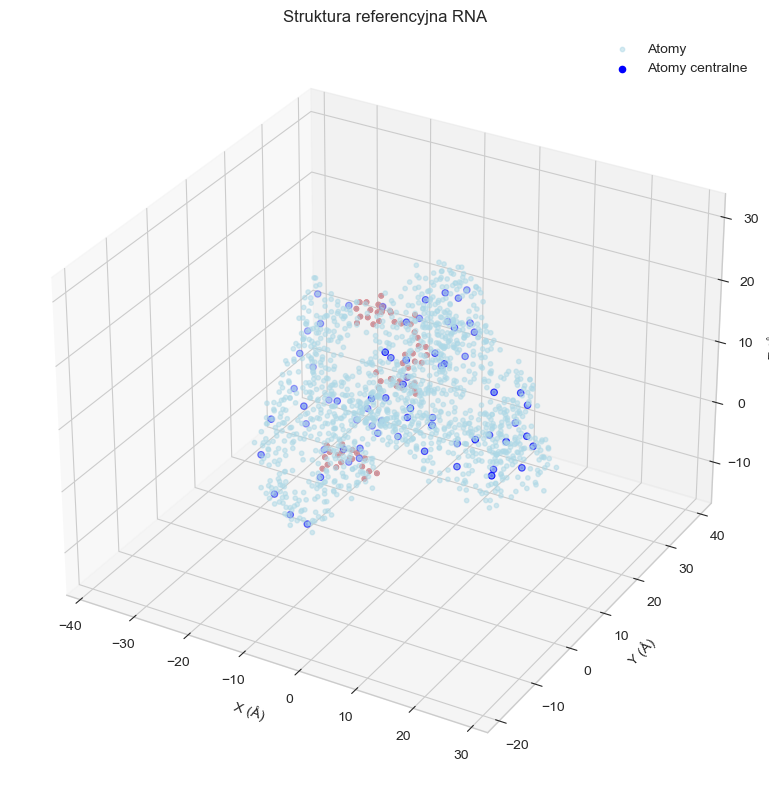

In [20]:
def plot_structure_3d(structure, title='Struktura molekularna', highlight_residues=None, highlight_color='red', highlight_radius=10):
    df = structure.df['ATOM']
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Wszystkie atomy
    ax.scatter(df['x_coord'], df['y_coord'], df['z_coord'], 
               s=10, c='lightblue', alpha=0.5, label='Atomy')
    
    # Atomy centralne (C1' dla RNA, CA dla białek)
    central_atoms = df[df['atom_name'].isin(["C1'", 'CA'])]
    ax.scatter(central_atoms['x_coord'], central_atoms['y_coord'], central_atoms['z_coord'], 
               s=20, c='blue', label='Atomy centralne')
    
    # Podświetlanie wybranych reszt
    if highlight_residues:
        for residue in highlight_residues:
            residue_atoms = df[df['residue_number'] == residue]
            ax.scatter(residue_atoms['x_coord'], residue_atoms['y_coord'], residue_atoms['z_coord'], 
                       s=highlight_radius, c=highlight_color, alpha=0.7)
    
    ax.set_title(title)
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Przykład użycia:
plot_structure_3d(target, title='Struktura referencyjna RNA', 
                 highlight_residues=[10, 20, 30],  # Przykładowe reszty do podświetlenia
                 highlight_color='red')

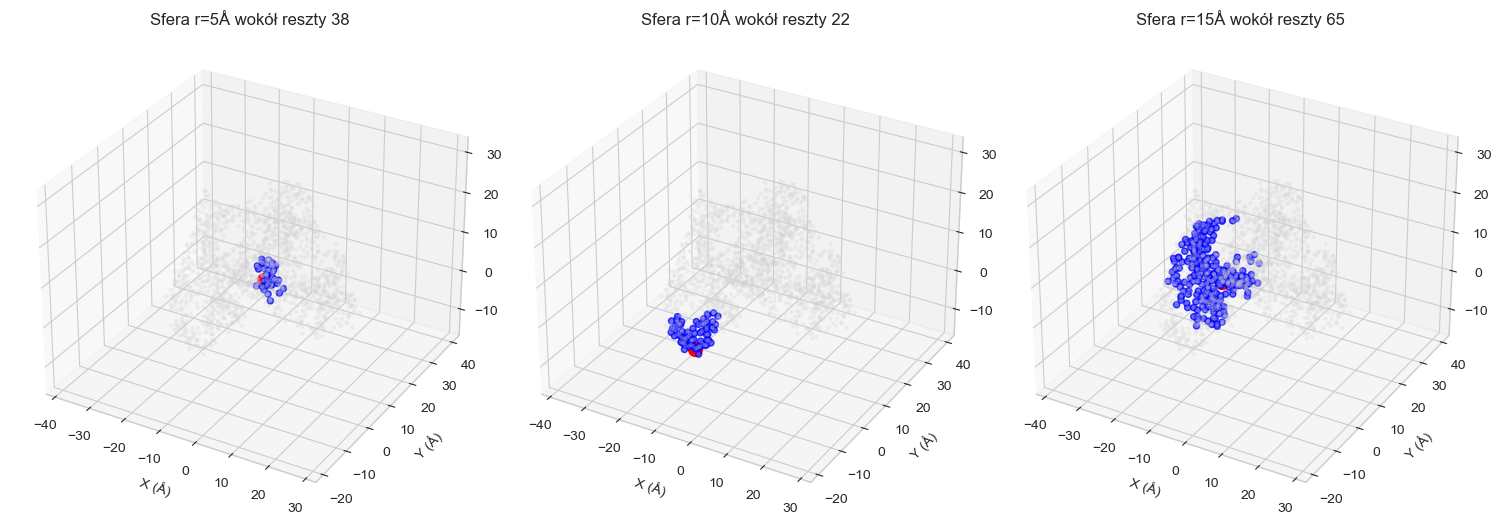

Liczba atomów centralnych: 69
Średnia liczba atomów w sferze: 131.0


In [21]:
def analyze_spheres(target, central_atom="C1'", sphere_radii=[5.0, 10.0, 15.0]):
    df = target.df['ATOM']  # Poprawione: target zamiast structure
    central_atoms = df[df['atom_name'] == central_atom]
    
    # Sprawdź czy istnieją atomy centralne
    if len(central_atoms) == 0:
        print(f"Brak atomów centralnych typu '{central_atom}' w strukturze")
        return None
    
    fig = plt.figure(figsize=(15, 10))
    
    for i, radius in enumerate(sphere_radii, 1):
        ax = fig.add_subplot(1, len(sphere_radii), i, projection='3d')
        
        # Wybierz losowy atom centralny do wizualizacji
        sample_atom = central_atoms.sample(1).iloc[0]
        center = [sample_atom['x_coord'], sample_atom['y_coord'], sample_atom['z_coord']]
        
        # Oblicz odległości od wybranego atomu centralnego
        distances = np.sqrt(
            (df['x_coord'] - center[0])**2 +
            (df['y_coord'] - center[1])**2 +
            (df['z_coord'] - center[2])**2
        )
        
        # Atomy wewnątrz sfery
        sphere_atoms = df[distances <= radius]
        
        # Wszystkie atomy
        ax.scatter(df['x_coord'], df['y_coord'], df['z_coord'], 
                   s=5, c='lightgray', alpha=0.2)
        
        # Atomy w sferze
        ax.scatter(sphere_atoms['x_coord'], sphere_atoms['y_coord'], sphere_atoms['z_coord'], 
                   s=20, c='blue', alpha=0.7)
        
        # Atom centralny
        ax.scatter([center[0]], [center[1]], [center[2]], 
                   s=100, c='red', marker='o')
        
        ax.set_title(f'Sfera r={radius}Å wokół reszty {sample_atom["residue_number"]}')
        ax.set_xlabel('X (Å)')
        ax.set_ylabel('Y (Å)')
        ax.set_zlabel('Z (Å)')
    
    plt.tight_layout()
    plt.show()
    
    # Zwróć informacje o sferach
    return {
        "central_atoms_count": len(central_atoms),
        "mean_atoms_per_sphere": np.mean([len(df[distances <= r]) for r in sphere_radii])
    }

# Przykład użycia:
sphere_info = analyze_spheres(target, central_atom="C1'", sphere_radii=[5, 10, 15])
if sphere_info:
    print(f"Liczba atomów centralnych: {sphere_info['central_atoms_count']}")
    print(f"Średnia liczba atomów w sferze: {sphere_info['mean_atoms_per_sphere']:.1f}")

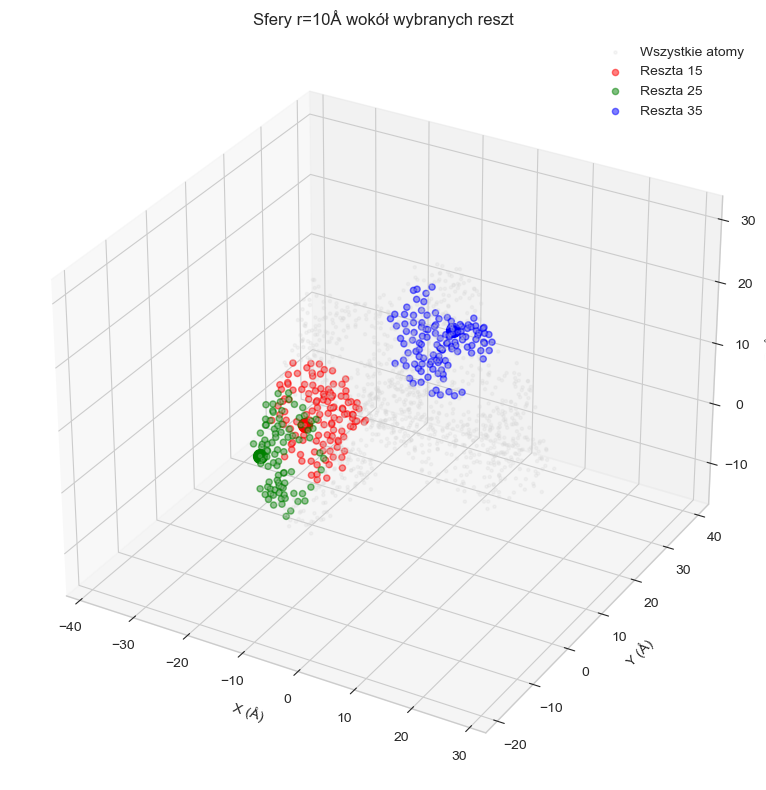

In [22]:
def visualize_multiple_spheres(target, central_atom="C1'", residue_numbers=[10, 20, 30], radius=10.0):
    df = target.df['ATOM']
    central_atoms = df[df['atom_name'] == central_atom]
    
    # Sprawdź czy istnieją atomy centralne
    if len(central_atoms) == 0:
        print(f"Brak atomów centralnych typu '{central_atom}' w strukturze")
        return
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Wszystkie atomy
    ax.scatter(df['x_coord'], df['y_coord'], df['z_coord'], 
               s=5, c='lightgray', alpha=0.2, label='Wszystkie atomy')
    
    colors = ['red', 'green', 'blue', 'purple', 'orange']
    
    for i, residue in enumerate(residue_numbers):
        # Znajdź atom centralny dla danej reszty
        residue_atoms = central_atoms[central_atoms['residue_number'] == residue]
        if len(residue_atoms) == 0:
            print(f"Brak atomu centralnego dla reszty {residue}")
            continue
        
        sample_atom = residue_atoms.iloc[0]
        center = [sample_atom['x_coord'], sample_atom['y_coord'], sample_atom['z_coord']]
        
        # Oblicz odległości
        distances = np.sqrt(
            (df['x_coord'] - center[0])**2 +
            (df['y_coord'] - center[1])**2 +
            (df['z_coord'] - center[2])**2
        )
        
        # Atomy w sferze
        sphere_atoms = df[distances <= radius]
        ax.scatter(sphere_atoms['x_coord'], sphere_atoms['y_coord'], sphere_atoms['z_coord'], 
                   s=20, c=colors[i % len(colors)], alpha=0.5, label=f'Reszta {residue}')
        
        # Atom centralny
        ax.scatter([center[0]], [center[1]], [center[2]], 
                   s=100, c=colors[i % len(colors)], marker='o')
    
    ax.set_title(f'Sfery r={radius}Å wokół wybranych reszt')
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Przykład użycia:
visualize_multiple_spheres(target, central_atom="C1'", residue_numbers=[15, 25, 35], radius=10)

FileNotFoundError: [Errno 2] No such file or directory: 'struktura1.pdb'

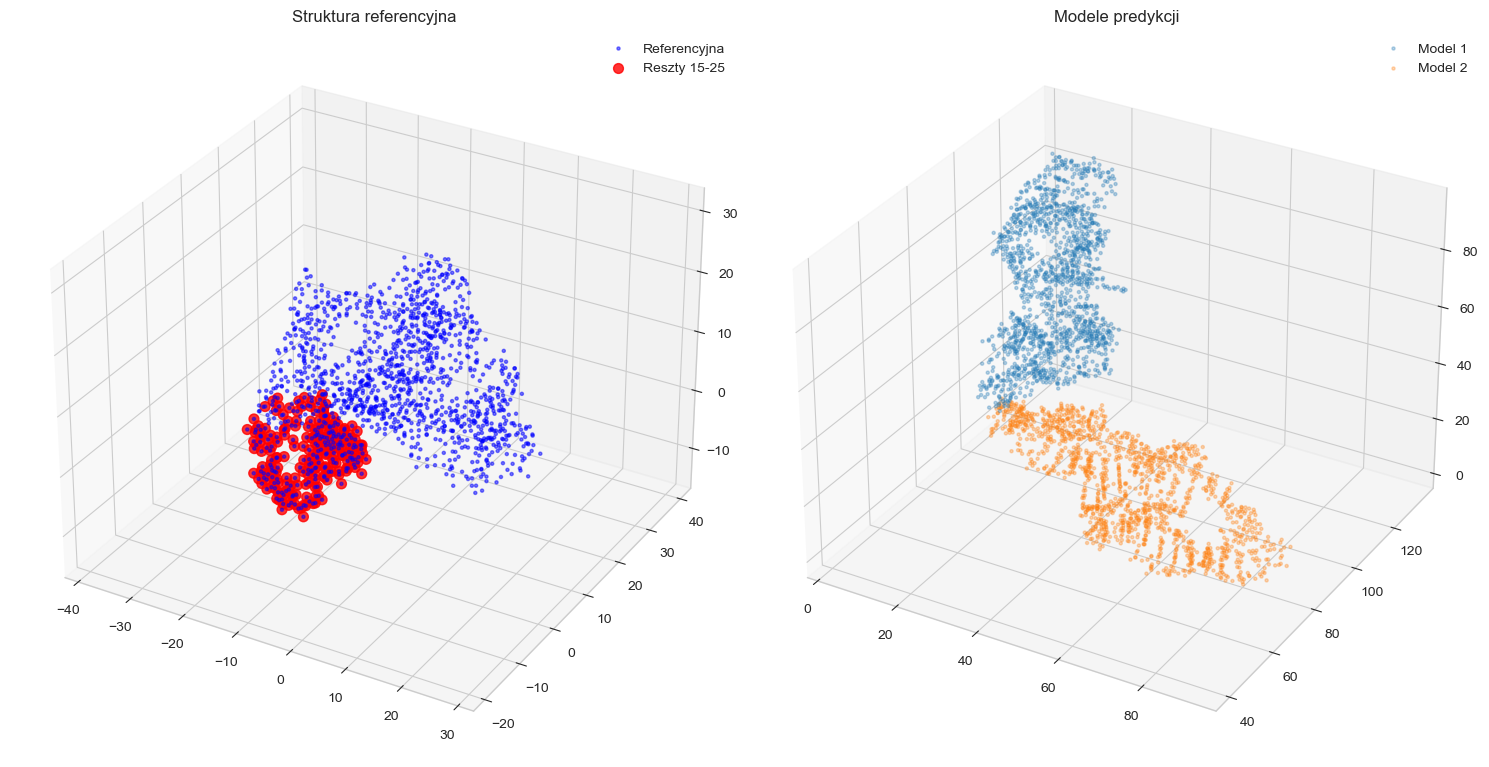

In [23]:
def compare_structures(target, models, residue_range=(10, 30)):
    fig = plt.figure(figsize=(15, 10))
    
    # Struktura referencyjna
    ax1 = fig.add_subplot(121, projection='3d')
    target_atoms = target.df['ATOM']
    ax1.scatter(target_atoms['x_coord'], target_atoms['y_coord'], target_atoms['z_coord'], 
                s=5, c='blue', alpha=0.5, label='Referencyjna')
    
    # Wybrane reszty
    residues = target_atoms[target_atoms['residue_number'].between(*residue_range)]
    ax1.scatter(residues['x_coord'], residues['y_coord'], residues['z_coord'], 
                s=50, c='red', alpha=0.8, label=f'Reszty {residue_range[0]}-{residue_range[1]}')
    
    ax1.set_title('Struktura referencyjna')
    ax1.legend()
    
    # Modele - pierwsze 3
    ax2 = fig.add_subplot(122, projection='3d')
    for i, (name, model) in enumerate(list(models.items())[:3]):
        model_atoms = model.df['ATOM']
        ax2.scatter(model_atoms['x_coord'], model_atoms['y_coord'], model_atoms['z_coord'], 
                    s=5, alpha=0.3, label=f'Model {i+1}')
    
    ax2.set_title('Modele predykcji')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Przykład użycia:
compare_structures(target, models, residue_range=(15, 25))